In [3]:
from src.utils.bq import BQ
from google.cloud import bigquery
import pandas as pd
bq = BQ()

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


# Test with subset of data 10000 customers who transact often

In [4]:
CUSTOMER_QUERY = """

SELECT customer_id 
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
GROUP BY customer_id 
ORDER BY count(*) DESC 
LIMIT 10000 OFFSET 1000

"""

customers = bq.to_dataframe(CUSTOMER_QUERY)["customer_id"].tolist()

In [5]:
customers[:10]

[914843,
 901305,
 1340317,
 1708687,
 3687312,
 2830620,
 2027982,
 1621347,
 2380879,
 1385821]

In [42]:
TRANSACTION_QUERY = """

SELECT customer_id, DATETIME(transaction_completed_datetime) as transaction_completed_datetime
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE customer_id IN UNNEST(@customer_ids)
AND transaction_completed_datetime IS NOT NULL

"""


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)
transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config)

In [43]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(transactions, 'customer_id', 'transaction_completed_datetime', freq='W')
summary.describe()

,frequency,recency,T
count,9228.000000,9228.000000,9228.000000
mean,17.904421,228.903663,275.992414
std,15.677765,144.134327,142.637886
min,0.000000,0.000000,1.000000
25%,7.000000,124.000000,171.000000
50%,14.000000,210.000000,257.000000
75%,25.000000,313.000000,361.000000
max,125.000000,1334.000000,1339.000000


In [ ]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 9228 subjects, a: 0.03, alpha: 12.25, b: 0.48, r: 0.98>

In [45]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.984351,0.011952,0.960925,1.007778
alpha,12.247522,0.203244,11.849163,12.645880
a,0.028790,0.001223,0.026394,0.031186
b,0.479843,0.015542,0.449380,0.510306


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

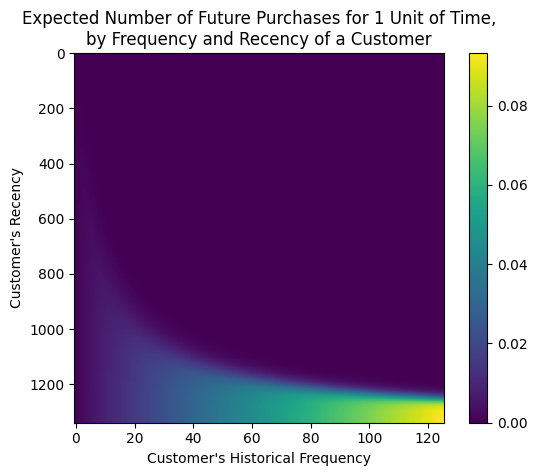

In [46]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

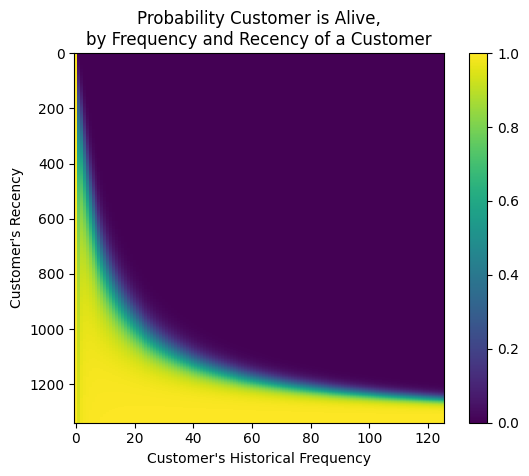

In [47]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

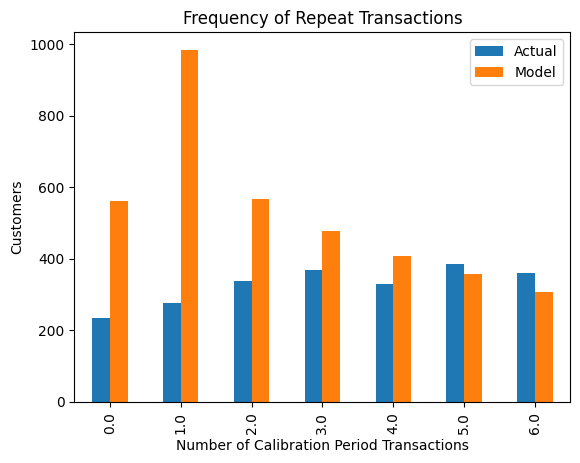

In [48]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [49]:
transactions["transaction_completed_datetime"]

0        2023-12-28 11:01:27.920056
1        2022-01-12 12:50:04.000000
2        2024-07-15 08:31:02.957366
3        2022-06-15 08:46:41.201704
4        2022-11-16 09:24:28.938460
                    ...            
202501   2024-12-27 15:26:28.392776
202502   2023-09-05 14:54:45.416938
202503   2023-12-01 19:32:09.621329
202504   2021-09-21 19:33:40.000000
202505   2024-01-29 15:32:02.093995
Name: transaction_completed_datetime, Length: 202506, dtype: datetime64[us]

In [50]:
from lifetimes.utils import calibration_and_holdout_data

# Keep datetime as datetime, don't convert to string
summary_cal_holdout = calibration_and_holdout_data(transactions, 'customer_id', 'transaction_completed_datetime',
                                        calibration_period_end='2023-01-01',
                                        observation_period_end='2025-01-01')
print(summary_cal_holdout.head())

             frequency_cal  recency_cal   T_cal  frequency_holdout  \
customer_id                                                          
812085                77.0       5765.0  8401.0                0.0   
812164                55.0       3404.0  3455.0                9.0   
812193                14.0       2593.0  3736.0                1.0   
812398                59.0       3484.0  3503.0               14.0   
812476                89.0       3510.0  3535.0                7.0   

             duration_holdout  
customer_id                    
812085                  731.0  
812164                  731.0  
812193                  731.0  
812398                  731.0  
812476                  731.0  


/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

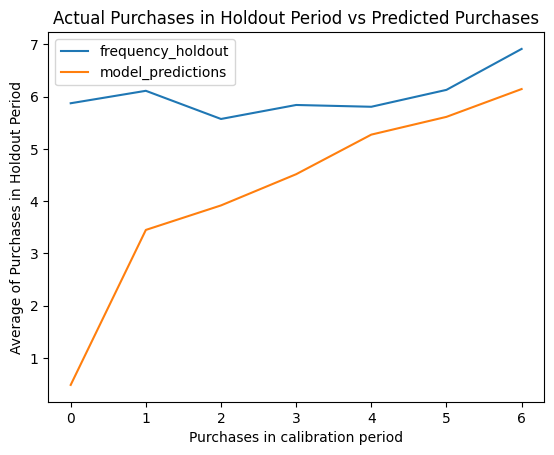

In [51]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)


In [52]:
t = 52
individual = summary.iloc[20]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

np.float64(2.6379677809859934)

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

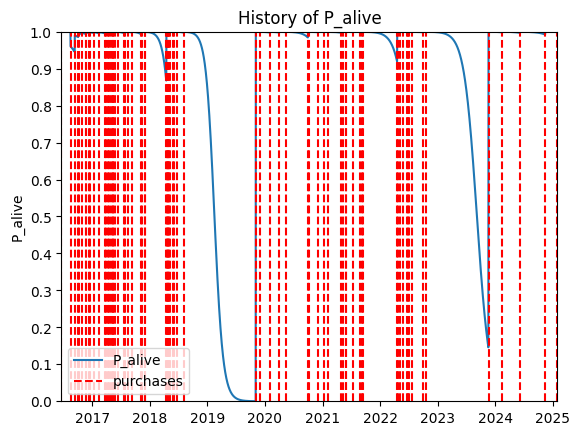

In [57]:
from lifetimes.plotting import plot_history_alive

id = 901305
lag = 100
sp_trans = transactions.loc[transactions['customer_id'] == id].copy()

sp_trans = transactions.loc[transactions['customer_id'] == id]
plot_history_alive(bgf, lag, sp_trans, 'transaction_completed_datetime')

In [60]:
TRANSACTION_QUERY = """

SELECT customer_id, 
DATETIME(transaction_completed_datetime) as transaction_completed_datetime,
inbound_payment_value - outbound_payment_value as spend
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE customer_id IN UNNEST(@customer_ids)
AND transaction_state = 'COMPLETED'

"""


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)
transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config)

In [61]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(transactions, 'customer_id', 'transaction_completed_datetime', monetary_value_col='spend', freq='W')
summary.describe()

,frequency,recency,T,monetary_value
count,8197.000000,8197.000000,8197.000000,8197.000000
mean,7.147371,161.818104,233.067098,854.477718
std,7.913623,135.782709,137.855724,1181.860860
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,53.000000,130.000000,312.700000
50%,5.000000,138.000000,213.000000,613.181818
75%,10.000000,240.000000,311.000000,1079.000000
max,87.000000,668.000000,673.000000,63406.250000


In [64]:
returning_customers_summary = summary[summary['frequency']>0]

In [65]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.072202
frequency,0.072202,1.000000


In [66]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 7280 subjects, p: 1.35, q: 2.85, v: 1366.23>


In [67]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

customer_id
812085     528.824579
812164     710.683155
812193     627.401655
812476    1327.566393
812751     738.976460
812892    1366.446787
812896    1728.315071
812958     829.724301
812959     845.517971
812991    1903.338884
dtype: float64


In [68]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 987.291226992233, Average profit: 962.1090456612692


In [70]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq='W'
).head(10))

customer_id
812085       0.000002
812164     178.652752
812193     337.497937
812476    2974.033902
812751      31.631218
812892    1350.985528
812896    1737.491751
812958     461.483331
812959     376.798428
812991    1314.999474
Name: clv, dtype: float64


/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# All customers

In [102]:
TRANSACTION_QUERY = """

SELECT customer_id as id, 
DATETIME(transaction_completed_datetime) as txn_date,
coalesce(inbound_payment_value - outbound_payment_value, 0) as value
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE transaction_state = 'COMPLETED'
AND DATETIME(transaction_completed_datetime) > '2020-01-01'

"""


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)

dtypes = {
    'id': 'int32',
    'txn_date': 'datetime64[ns]',
    'value': 'int32'
}

transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

In [103]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(transactions, 'id', 'txn_date', monetary_value_col='value', freq='W')
summary.describe()

,frequency,recency,T,monetary_value
count,315136.000000,315136.000000,315136.000000,315136.000000
mean,0.743777,23.024326,127.132720,255.070826
std,2.337248,52.597797,81.584384,717.542703
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,59.000000,0.000000
50%,0.000000,0.000000,118.000000,0.000000
75%,1.000000,6.000000,193.000000,187.500000
max,158.000000,295.000000,295.000000,63406.250000


In [104]:
returning_customers_summary = summary[summary['frequency']>0]
returning_customers_summary.describe()

,frequency,recency,T,monetary_value
count,92586.000000,92586.000000,92586.000000,92586.000000
mean,2.531603,78.368155,157.086125,868.187413
std,3.750676,71.269167,78.156831,1104.612088
min,1.000000,1.000000,1.000000,0.000000
25%,1.000000,17.000000,92.000000,289.000000
50%,1.000000,59.000000,157.000000,570.000000
75%,3.000000,123.000000,223.000000,1058.000000
max,158.000000,295.000000,295.000000,63406.250000


In [141]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.181841,0.001000,0.179882,0.183800
alpha,15.998284,0.154796,15.694884,16.301685
a,0.632122,0.011618,0.609351,0.654893
b,1.349470,0.031051,1.288610,1.410329


<Axes: title={'center': 'Expected Number of Future Purchases for 260 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

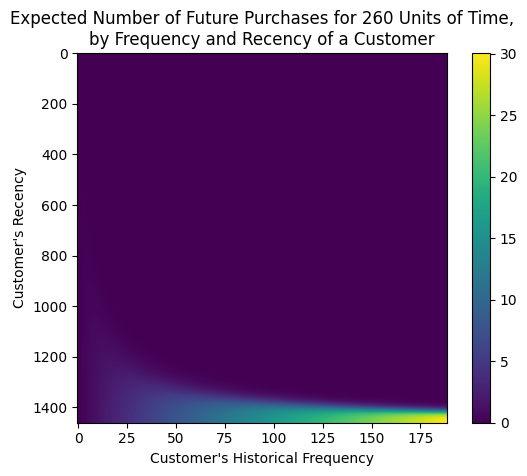

In [149]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf, T = 52 * 5)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

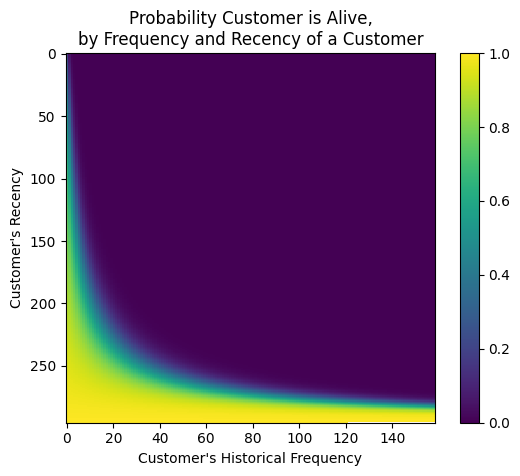

In [133]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

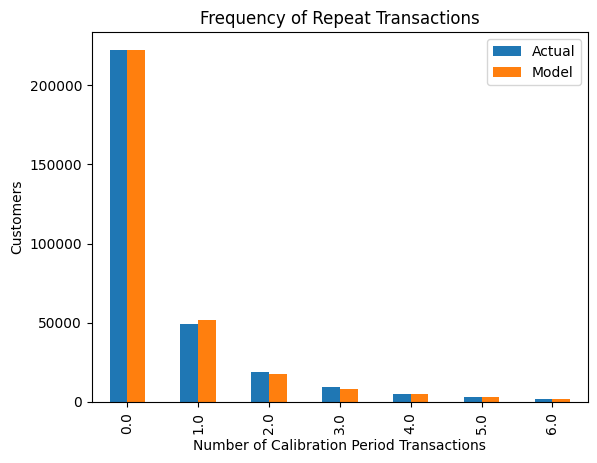

In [142]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [143]:
from lifetimes.utils import calibration_and_holdout_data

# Keep datetime as datetime, don't convert to string
summary_cal_holdout = calibration_and_holdout_data(transactions, 'id', 'txn_date',
                                        calibration_period_end='2024-01-01',
                                        observation_period_end='2025-01-01')
print(summary_cal_holdout.head())

        frequency_cal  recency_cal   T_cal  frequency_holdout  \
id                                                              
812113            0.0          0.0   636.0                0.0   
812192            0.0          0.0   203.0                1.0   
812193            0.0          0.0    94.0                0.0   
812202            1.0        494.0  1330.0                0.0   
812243            1.0        729.0  1313.0                0.0   

        duration_holdout  
id                        
812113             366.0  
812192             366.0  
812193             366.0  
812202             366.0  
812243             366.0  


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

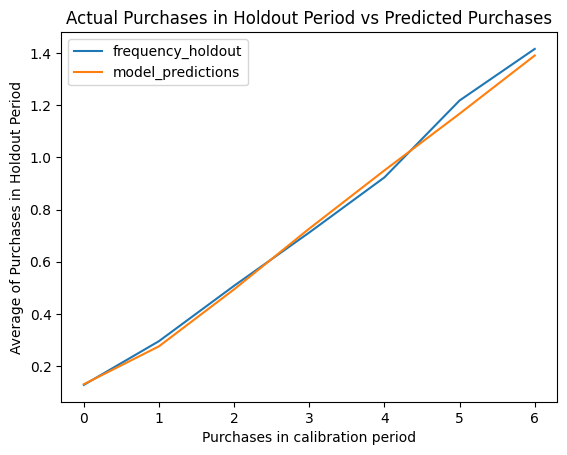

In [144]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [111]:
t = 52
individual = summary.iloc[20]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

np.float64(0.044200923287375626)

<Axes: title={'center': 'History of P_alive'}, ylabel='P_alive'>

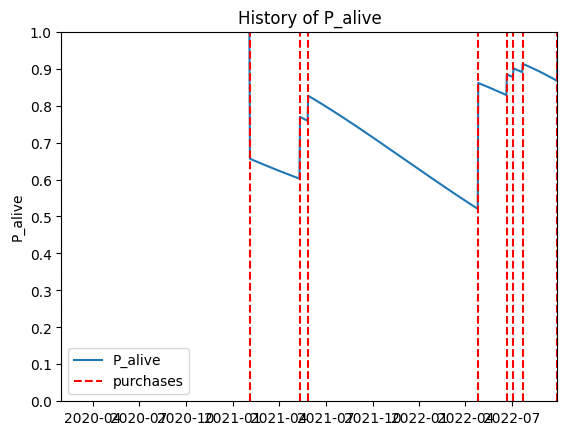

In [145]:
from lifetimes.plotting import plot_history_alive

id = 901305
lag = 100
sp_trans = transactions.loc[transactions['id'] == id].copy()

sp_trans = transactions.loc[transactions['id'] == id]
plot_history_alive(bgf, lag, sp_trans, 'txn_date')

In [146]:
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.317757
frequency,0.317757,1.000000


In [147]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
summary_gt_0 = summary[summary['frequency'] > 0]
summary_gt_0 = summary_gt_0[summary_gt_0['monetary_value'] > 0]

ggf.fit(summary_gt_0['frequency'],
        summary_gt_0['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 92585 subjects, p: 1.34, q: 3.06, v: 1390.12>


In [148]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

id
812113    905.438211
812192    931.297774
812193    905.438211
812202    711.994470
812243    675.312443
812247    905.438211
812257    830.323591
812296    905.438211
812334    905.438211
812360    749.859789
dtype: float64


In [115]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 904.0424333166931, Average profit: 868.1874129433605


### As a workflow

In [2]:
# Complete Customer Lifetime Value Analysis - All in One Cell
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data
TRANSACTION_QUERY = """
SELECT customer_id as id, 
DATETIME(transaction_completed_datetime) as txn_date,
coalesce(inbound_payment_value - outbound_payment_value, 0) as value
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE transaction_completed_datetime is not null
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'id': 'int32',
    'txn_date': 'datetime64[ns]',
    'value': 'int32'
}

transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

# Create RFM summary
summary = summary_data_from_transaction_data(transactions, 'id', 'txn_date', monetary_value_col='value', freq='W')
# summary = summary[summary['frequency'] > 1]
# Fit BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit Gamma-Gamma model (only on customers with purchases and positive monetary value)
ggf = GammaGammaFitter(penalizer_coef=0)
summary_gt_0 = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]
ggf.fit(summary_gt_0['frequency'], summary_gt_0['monetary_value'])

# Create comprehensive customer analysis dataframe - start with summary data
customer_analysis = summary.copy()

# Probability alive
customer_analysis['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)

# Expected purchases next 5 years (260 weeks)
customer_analysis['expected_purchases_5y'] = bgf.predict(
    260,  # 5 years in weeks
    summary['frequency'],
    summary['recency'], 
    summary['T']
)

# Average value per purchase - all customers
customer_analysis['avg_order_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# CLV for next 5 years - all customers
customer_analysis['clv_5y'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=260,  # 5 years in weeks
    discount_rate=0.01,  # weekly discount rate
    freq='W'
)

# Additional useful metrics
customer_analysis['customer_age_weeks'] = customer_analysis['T']
customer_analysis['days_since_last_purchase'] = customer_analysis['recency'] * 7  # Convert weeks to days
customer_analysis['purchase_rate_per_week'] = customer_analysis['frequency'] / customer_analysis['T']
customer_analysis['purchase_rate_per_week'] = customer_analysis['purchase_rate_per_week'].fillna(0)

# Customer segments based on CLV - handle any inf/nan values
clv_finite = customer_analysis['clv_5y'].replace([np.inf, -np.inf], np.nan)
valid_clv_mask = clv_finite.notna()

if valid_clv_mask.sum() > 0:
    # Create quartiles only for customers with valid CLV
    quartiles = pd.qcut(clv_finite[valid_clv_mask], 4, labels=['Low', 'Medium', 'High', 'Premium'], duplicates='drop')
    customer_analysis['clv_quartile'] = 'No CLV'
    customer_analysis.loc[valid_clv_mask, 'clv_quartile'] = quartiles
else:
    customer_analysis['clv_quartile'] = 'No CLV'

# Customer status based on probability alive
def get_customer_status(p_alive):
    if p_alive <= 0.3:
        return 'Lost'
    elif p_alive < 0.6:
        return 'Lapsing'
    else:
        return 'Active'

customer_analysis['status'] = customer_analysis['p_alive'].apply(get_customer_status)

print("Customer Analysis Summary:")
print(f"Total customers: {len(customer_analysis):,}")
print(f"Customers with valid CLV: {valid_clv_mask.sum():,}")
print(f"Customer Status Distribution:")
print(customer_analysis['status'].value_counts())
print(f"\nCLV Quartile Distribution:")
print(customer_analysis['clv_quartile'].value_counts())
print(f"\nAverage CLV (5y): ${customer_analysis['clv_5y'].mean():.2f}")
print(f"Total CLV (5y): ${customer_analysis['clv_5y'].sum():,}")

customer_analysis.head(10)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Customer Analysis Summary:
Total customers: 1,335,352
Customers with valid CLV: 1,335,352
Customer Status Distribution:
status
Active     1054896
Lost        142308
Lapsing     138148
Name: count, dtype: int64

CLV Quartile Distribution:
clv_quartile
Low        334510
Premium    333838
Medium     333508
High       333496
Name: count, dtype: int64

Average CLV (5y): $761.39
Total CLV (5y): $1,016,729,886.5718892


,frequency,recency,T,monetary_value,p_alive,expected_purchases_5y,avg_order_value,clv_5y,customer_age_weeks,days_since_last_purchase,purchase_rate_per_week,clv_quartile,status
id,,,,,,,,,,,,,
812085,58.0,824.0,1340.0,548.689655,6.899690e-11,7.305119e-10,550.687641,5.787967e-07,1340.0,5768.0,0.043284,Low,Lost
812086,1.0,80.0,596.0,516.000000,2.009879e-01,9.267406e-02,584.387121,7.593689e+01,596.0,560.0,0.001678,Low,Lost
812092,0.0,0.0,612.0,0.000000,1.000000e+00,6.775164e-02,632.909256,6.122542e+01,612.0,0.0,0.000000,Low,Active
812098,0.0,0.0,350.0,0.000000,1.000000e+00,1.120449e-01,632.909256,9.807993e+01,350.0,0.0,0.000000,Low,Active
812102,5.0,293.0,384.0,641.400000,6.949761e-01,2.034458e+00,639.532921,1.738174e+03,384.0,2051.0,0.013021,Premium,Active
812104,11.0,477.0,641.0,693.000000,4.230569e-01,1.699713e+00,686.175180,1.608800e+03,641.0,3339.0,0.017161,Premium,Lapsing
812113,6.0,346.0,381.0,779.166667,8.540150e-01,2.996331e+00,751.345891,3.001093e+03,381.0,2422.0,0.015748,Premium,Active
812115,0.0,0.0,528.0,0.000000,1.000000e+00,7.756220e-02,632.909256,6.953848e+01,528.0,0.0,0.000000,Low,Active
812123,0.0,0.0,219.0,0.000000,1.000000e+00,1.671697e-01,632.909256,1.420903e+02,219.0,0.0,0.000000,Low,Active


In [1]:
# Complete Customer Lifetime Value Analysis - All in One Cell
import pandas as pd
import numpy as np
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data
TRANSACTION_QUERY = """
SELECT customer_id as id, 
DATETIME(transaction_completed_datetime) as txn_date,
coalesce(inbound_payment_value - outbound_payment_value, 0) as value
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE transaction_state = 'COMPLETED'
AND DATETIME(transaction_completed_datetime) > '2020-01-01'
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'id': 'int32',
    'txn_date': 'datetime64[ns]',
    'value': 'int32'
}

transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

# Create RFM summary
summary = summary_data_from_transaction_data(transactions, 'id', 'txn_date', monetary_value_col='value', freq='W')
# summary = summary[summary['frequency'] > 1]
# Fit BG/NBD model
bgf = ParetoNBDFitter(penalizer_coef=0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit Gamma-Gamma model (only on customers with purchases and positive monetary value)
ggf = GammaGammaFitter(penalizer_coef=0)
summary_gt_0 = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]
ggf.fit(summary_gt_0['frequency'], summary_gt_0['monetary_value'])

# Create comprehensive customer analysis dataframe - start with summary data
customer_analysis = summary.copy()

# Probability alive
customer_analysis['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)

# Expected purchases next 5 years (260 weeks)
customer_analysis['expected_purchases_5y'] = bgf.predict(
    260,  # 5 years in weeks
    summary['frequency'],
    summary['recency'], 
    summary['T']
)

# Average value per purchase - all customers
customer_analysis['avg_order_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# CLV for next 5 years - all customers
customer_analysis['clv_5y'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=260,  # 5 years in weeks
    discount_rate=0.01,  # weekly discount rate
    freq='W'
)

# Additional useful metrics
customer_analysis['customer_age_weeks'] = customer_analysis['T']
customer_analysis['days_since_last_purchase'] = customer_analysis['recency'] * 7  # Convert weeks to days
customer_analysis['purchase_rate_per_week'] = customer_analysis['frequency'] / customer_analysis['T']
customer_analysis['purchase_rate_per_week'] = customer_analysis['purchase_rate_per_week'].fillna(0)

# Customer segments based on CLV - handle any inf/nan values
clv_finite = customer_analysis['clv_5y'].replace([np.inf, -np.inf], np.nan)
valid_clv_mask = clv_finite.notna()

if valid_clv_mask.sum() > 0:
    # Create quartiles only for customers with valid CLV
    quartiles = pd.qcut(clv_finite[valid_clv_mask], 4, labels=['Low', 'Medium', 'High', 'Premium'], duplicates='drop')
    customer_analysis['clv_quartile'] = 'No CLV'
    customer_analysis.loc[valid_clv_mask, 'clv_quartile'] = quartiles
else:
    customer_analysis['clv_quartile'] = 'No CLV'

# Customer status based on probability alive
def get_customer_status(p_alive):
    if p_alive <= 0.3:
        return 'Lost'
    elif p_alive < 0.6:
        return 'Lapsing'
    else:
        return 'Active'

customer_analysis['status'] = customer_analysis['p_alive'].apply(get_customer_status)

print("Customer Analysis Summary:")
print(f"Total customers: {len(customer_analysis):,}")
print(f"Customers with valid CLV: {valid_clv_mask.sum():,}")
print(f"Customer Status Distribution:")
print(customer_analysis['status'].value_counts())
print(f"\nCLV Quartile Distribution:")
print(customer_analysis['clv_quartile'].value_counts())
print(f"\nAverage CLV (5y): ${customer_analysis['clv_5y'].mean():.2f}")
print(f"Total CLV (5y): ${customer_analysis['clv_5y'].sum():,}")

customer_analysis.head(10)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Customer Analysis Summary:
Total customers: 315,972
Customers with valid CLV: 315,972
Customer Status Distribution:
status
Lapsing    119280
Lost       105786
Active      90906
Name: count, dtype: int64

CLV Quartile Distribution:
clv_quartile
Low        79434
Medium     79147
High       78774
Premium    78617
Name: count, dtype: int64

Average CLV (5y): $1279.82
Total CLV (5y): $404,387,045.1156086


,frequency,recency,T,monetary_value,p_alive,expected_purchases_5y,avg_order_value,clv_5y,customer_age_weeks,days_since_last_purchase,purchase_rate_per_week,clv_quartile,status
id,,,,,,,,,,,,,
812113,0.0,0.0,177.0,0.0,0.249198,0.137410,905.593616,171.559362,177.0,0.0,0.000000,Low,Lost
812192,1.0,63.0,115.0,971.0,0.801012,1.618968,931.392941,2043.447406,115.0,441.0,0.008696,Premium,Active
812193,0.0,0.0,100.0,0.0,0.344587,0.269118,905.593616,328.567494,100.0,0.0,0.000000,Medium,Lapsing
812202,1.0,70.0,276.0,415.0,0.447178,0.500172,712.080641,500.432080,276.0,490.0,0.003623,High,Lapsing
812243,1.0,104.0,274.0,322.0,0.614931,0.691642,675.397109,656.147114,274.0,728.0,0.003650,High,Active
812247,0.0,0.0,263.0,0.0,0.193377,0.080223,905.593616,101.864566,263.0,0.0,0.000000,Low,Lost
812257,1.0,23.0,61.0,715.0,0.713979,1.968113,830.414615,2167.757062,61.0,161.0,0.016393,Premium,Active
812296,0.0,0.0,258.0,0.0,0.195864,0.082442,905.593616,104.595368,258.0,0.0,0.000000,Low,Lost
812334,0.0,0.0,22.0,0.0,0.630650,0.817728,905.593616,959.444136,22.0,0.0,0.000000,High,Active


In [1]:
# Complete Customer Lifetime Value Analysis - All in One Cell
import pandas as pd
import numpy as np
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data
TRANSACTION_QUERY = """
SELECT customer_id as id, 
DATETIME(transaction_completed_datetime) as txn_date,
coalesce(inbound_payment_value - outbound_payment_value, 0) as value
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE transaction_completed_datetime is not null
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'id': 'int32',
    'txn_date': 'datetime64[ns]',
    'value': 'int32'
}

transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

# Create RFM summary
summary = summary_data_from_transaction_data(transactions, 'id', 'txn_date', monetary_value_col='value', freq='W')
# summary = summary[summary['frequency'] > 1]
# Fit BG/NBD model
bgf = ParetoNBDFitter(penalizer_coef=0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit Gamma-Gamma model (only on customers with purchases and positive monetary value)
ggf = GammaGammaFitter(penalizer_coef=0)
summary_gt_0 = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]
ggf.fit(summary_gt_0['frequency'], summary_gt_0['monetary_value'])

# Create comprehensive customer analysis dataframe - start with summary data
customer_analysis = summary.copy()

# Probability alive
customer_analysis['p_alive'] = bgf.conditional_probability_alive(
    summary['frequency'], 
    summary['recency'], 
    summary['T']
)

# Expected purchases next 5 years (260 weeks)
customer_analysis['expected_purchases_5y'] = bgf.predict(
    260,  # 5 years in weeks
    summary['frequency'],
    summary['recency'], 
    summary['T']
)

# Average value per purchase - all customers
customer_analysis['avg_order_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'],
    summary['monetary_value']
)

# CLV for next 5 years - all customers
customer_analysis['clv_5y'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=260,  # 5 years in weeks
    discount_rate=0.01,  # weekly discount rate
    freq='W'
)

# Additional useful metrics
customer_analysis['customer_age_weeks'] = customer_analysis['T']
customer_analysis['days_since_last_purchase'] = customer_analysis['recency'] * 7  # Convert weeks to days
customer_analysis['purchase_rate_per_week'] = customer_analysis['frequency'] / customer_analysis['T']
customer_analysis['purchase_rate_per_week'] = customer_analysis['purchase_rate_per_week'].fillna(0)

# Customer segments based on CLV - handle any inf/nan values
clv_finite = customer_analysis['clv_5y'].replace([np.inf, -np.inf], np.nan)
valid_clv_mask = clv_finite.notna()

if valid_clv_mask.sum() > 0:
    # Create quartiles only for customers with valid CLV
    quartiles = pd.qcut(clv_finite[valid_clv_mask], 4, labels=['Low', 'Medium', 'High', 'Premium'], duplicates='drop')
    customer_analysis['clv_quartile'] = 'No CLV'
    customer_analysis.loc[valid_clv_mask, 'clv_quartile'] = quartiles
else:
    customer_analysis['clv_quartile'] = 'No CLV'

# Customer status based on probability alive
def get_customer_status(p_alive):
    if p_alive <= 0.3:
        return 'Lost'
    elif p_alive < 0.6:
        return 'Lapsing'
    else:
        return 'Active'

customer_analysis['status'] = customer_analysis['p_alive'].apply(get_customer_status)

print("Customer Analysis Summary:")
print(f"Total customers: {len(customer_analysis):,}")
print(f"Customers with valid CLV: {valid_clv_mask.sum():,}")
print(f"Customer Status Distribution:")
print(customer_analysis['status'].value_counts())
print(f"\nCLV Quartile Distribution:")
print(customer_analysis['clv_quartile'].value_counts())
print(f"\nAverage CLV (5y): ${customer_analysis['clv_5y'].mean():.2f}")
print(f"Total CLV (5y): ${customer_analysis['clv_5y'].sum():,}")

customer_analysis.head(10)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in logaddexp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in logaddexp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by

Customer Analysis Summary:
Total customers: 1,335,199
Customers with valid CLV: 1,335,186
Customer Status Distribution:
status
Lost       602430
Lapsing    378587
Active     354182
Name: count, dtype: int64

CLV Quartile Distribution:
clv_quartile
Low        334886
Premium    333797
High       333796
Medium     332707
No CLV         13
Name: count, dtype: int64

Average CLV (5y): $937.91
Total CLV (5y): $1,252,290,451.0061872


,frequency,recency,T,monetary_value,p_alive,expected_purchases_5y,avg_order_value,clv_5y,customer_age_weeks,days_since_last_purchase,purchase_rate_per_week,clv_quartile,status
id,,,,,,,,,,,,,
812085,58.0,824.0,1340.0,548.689655,2.060904e-10,2.202790e-09,550.686984,0.000002,1340.0,5768.0,0.043284,Low,Lost
812086,1.0,80.0,596.0,516.000000,1.717558e-01,1.036229e-01,584.369550,87.463448,596.0,560.0,0.001678,Low,Lost
812092,0.0,0.0,612.0,0.000000,8.691088e-02,1.876285e-02,632.875829,17.170215,612.0,0.0,0.000000,Low,Lost
812098,0.0,0.0,350.0,0.000000,1.347120e-01,4.672737e-02,632.875829,41.728154,350.0,0.0,0.000000,Low,Lost
812102,5.0,293.0,384.0,641.400000,8.423219e-01,2.613773e+00,639.525468,2368.609455,384.0,2051.0,0.013021,Premium,Active
812104,11.0,477.0,641.0,693.000000,5.814374e-01,2.413767e+00,686.170961,2399.428870,641.0,3339.0,0.017161,Premium,Lapsing
812113,6.0,346.0,381.0,779.166667,9.603364e-01,3.537019e+00,751.337959,3764.319033,381.0,2422.0,0.015748,Premium,Active
812115,0.0,0.0,528.0,0.000000,9.784228e-02,2.402985e-02,632.875829,21.854299,528.0,0.0,0.000000,Low,Lost
812123,0.0,0.0,219.0,0.000000,1.896325e-01,9.452519e-02,632.875829,82.617153,219.0,0.0,0.000000,Low,Lost
